# Exploring Kitti Dataset
This notebook is only to explore the Kitti dataset and get some useful information about it.

## Object Detection Evaluation 2012
http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d

![Object Detection Evaluation 2012 Dataset Sample](http://www.cvlibs.net/datasets/kitti/images/header_object.jpg)

The object detection and object orientation estimation benchmark consists of 7481 training images and 7518 test images, comprising a total of 80.256 labeled objects. All images are color and saved as png. For evaluation, we compute precision-recall curves for object detection and orientation-similarity-recall curves for joint object detection and orientation estimation. In the latter case not only the object 2D bounding box has to be located correctly, but also the orientation estimate in bird's eye view is evaluated. To rank the methods we compute average precision and average orientation similiarity. We require that all methods use the same parameter set for all test pairs. Our development kit provides details about the data format as well as MATLAB / C++ utility functions for reading and writing the label files.

Kitti <br/>
&nbsp;&nbsp;&nbsp;↳ data_object_image_2 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ testing <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ image_2 _(7518 img)_ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ training <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ image_2 _(7481 img)_ <br/>
&nbsp;&nbsp;&nbsp;↳ data_object_label_2 <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ training <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳ label_2 _(7481 txt)_ <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↳xml _(empty)_ <br/>
              <br/>
&nbsp;&nbsp;&nbsp;↳ label_test.txt _(images used for testing)_ <br/>
&nbsp;&nbsp;&nbsp;↳ label_train.txt _(images used for training)_ <br/>
&nbsp;&nbsp;&nbsp;↳ table-xml.el _()_ <br/>
&nbsp;&nbsp;&nbsp;↳ xml _(empty)_ <br/>

In [9]:
absolute_path = "/data2/Kitti/left_12g/"

train_path_im = "data_object_image_2/training/image_2/"
test_path_im = "data_object_image_2/testing/image_2/"

train_path_label = "data_object_label_2/training/label_2/"

fig_width = 30
fig_height = 15

default_type_to_display = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
default_info_to_display = ['alpha', 'bbox']
color_type ={
    'Car':            '#ff0000',   # Red
    'Van':            '#ffff00',   # Yellow
    'Truck':          '#ff00ff',   # Fuchsia
    'Pedestrian':     '#33cc33',   # Green
    'Person_sitting': '#00ffff',   # Light Blue
    'Cyclist':        '#ff9933',   # Orange
    'Tram':           '#0000ff',   # Blue      
    'Misc':           '#996633',   # Brown
    'DontCare':       '#9900ff',   # Violet
}

# To import the picture
from scipy import misc

import math

# To display the image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Label Management
The labels corresponding to the images of the training set are all in the folder: _Kitti/data_object_label_2/training/label_2/_. They are _.txt_ files where all values (numerical or strings) are separated via spaces,
each row corresponds to one object:
- __Type of object__ (1): 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'
- __Truncated__ (1): Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries
- __Occluded__ (1): Integer (0,1,2,3) indicating occlusion state:
  - 0 = fully visible
  - 1 = partly occluded
  - 2 = largely occluded
  - 3 = unknown
- __Observation angle__ alpha of object (1): ranging \[-pi..pi\]
- __Bbox of object in the image__ (4): x_min, y_min, x_max, y_max pixel coordinates (0-based index).
- __3D object dimensions__ (3): height, width, length (in meters)
- __3D object location__ (3): x,y,z in camera coordinates (in meters)
- __Rotation r_y__ (3): around Y-axis in camera coordinates \[-pi..pi\]
- __Score__ (1): Only for results Float, indicating confidence in detection, needed for p/r curves, higher is better.

In [11]:
def create_label_path(im_id, im_set, db_absolute_path = absolute_path):
    """
    This function create the absolute path to the label of an image
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    
    Returns:
    label_path -- absolute path to the label
    """
    len_filename = 6
    
    label_filename = str(im_id).zfill(len_filename) + ".txt"
    
    label_path = db_absolute_path + globals()[im_set +'_path_label'] + label_filename
    
    return label_path

In [12]:
def import_labels(im_id, im_set, db_absolute_path = absolute_path):
    """
    This import the labels of an image in a list of dictionnary
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    
    Returns:
    objects -- list of dictionnary containing all the information on the objects in the file
    """
    # Create file absolute path
    label_path = create_label_path(im_id, im_set, db_absolute_path)
    
    objects = []
    
    # Import 
    with open(label_path) as f:
        for line in f:
            # Parse line
            line_parsed = line.strip().split(' ')
            
            # Fill the dictionary with the values
            object_dict = {}
            object_dict['type']        = line_parsed[0]
            object_dict['truncated']   = float(line_parsed[1])
            object_dict['occluded']    = int(line_parsed[2])
            object_dict['alpha']       = float(line_parsed[3])
            object_dict['bbox']        = {'x_min': float(line_parsed[4]),
                                          'y_min': float(line_parsed[5]),
                                          'x_max': float(line_parsed[6]),
                                          'y_max': float(line_parsed[7])}
            object_dict['3D_dim']      = {'height': float(line_parsed[8]),
                                          'width' : float(line_parsed[9]),
                                          'length': float(line_parsed[10])}
            object_dict['3D_loc']      = {'x': float(line_parsed[11]),
                                          'y': float(line_parsed[12]),
                                          'z': float(line_parsed[13])}
            object_dict['rotation_y']  = float(line_parsed[14])
            
            # Add Score [optional in the file]
            if len(line_parsed) > 15:
                object_dict['score']       = float(line_parsed[15])
            
            # Append the dictionary to the list of object in the picture
            objects.append(object_dict)
            
    return objects

In [13]:
print(absolute_path)
label = import_labels(6413, 'train')
print(label[0])

/data2/Kitti/left_12g/
{'3D_dim': {'length': 3.2, 'width': 1.66, 'height': 1.61}, 'bbox': {'x_max': 619.47, 'y_max': 228.66, 'y_min': 179.81, 'x_min': 569.02}, 'truncated': 0.0, '3D_loc': {'x': -0.58, 'z': 25.64, 'y': 1.87}, 'rotation_y': -1.58, 'alpha': -1.56, 'occluded': 0, 'type': 'Car'}


In [17]:
def print_info(labels, type_to_display = default_type_to_display, info_to_display = default_info_to_display):
    """
    This display the information about the objects in a friendly way
    
    Argument:
    labels            -- list of dictionaries containing the information about the object to display
    type_to_display   -- list of types of object to display
    info_to_display   -- list of the name of the information to display from the dictionaries
    
    Returns:
    Print a table with all the information in ASCII
    """
    
    # Variable to control the size of the cells in the table
    len_cell_type = 16
    len_cell = 12

    # Create Header
    header_to_print = '|' + 'type'.ljust(len_cell_type) + '|'
    for info_descr in info_to_display:
        info = labels[0][info_descr]
        if not isinstance(info, dict):
            header_to_print += info_descr.ljust(len_cell - 2).rjust(len_cell) + '|'
        else:
            for key in info:
                header_to_print += key.ljust(len_cell - 2).rjust(len_cell) + '|'
    
    # Print Header
    print(''.ljust(len(header_to_print), '-'))
    print(header_to_print)     
    print(''.ljust(len(header_to_print), '-'))
    print(''.ljust(len(header_to_print), '-'))
    
    # Extract only object corresponding to a certain type
    for type in type_to_display:
        list_dic = [dic for dic in labels if dic['type'] == type]
        
        # Create a str with the information for each object in the list
        for dic in list_dic:
            info_to_print = '|' + dic['type'].ljust(len_cell_type) + '|' 
            for info_descr in info_to_display:
                info = dic[info_descr]
                if not isinstance(info, dict):
                    info_to_print += str(info).ljust(len_cell - 2).rjust(len_cell) + '|'
                else:
                    for _, item in info.items():
                        info_to_print += str(item).ljust(len_cell - 2).rjust(len_cell) + '|'

            print(info_to_print)
            print(''.ljust(len(info_to_print), '-'))


    

In [18]:
print_info(import_labels(4321, 'train'), ['Pedestrian'], ['bbox'])

----------------------------------------------------------------------
|type            |  x_max     |  y_max     |  y_min     |  x_min     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Pedestrian      |  596.1     |  222.73    |  163.1     |  577.1     |
----------------------------------------------------------------------
|Pedestrian      |  614.7     |  222.79    |  160.34    |  597.03    |
----------------------------------------------------------------------
|Pedestrian      |  548.49    |  319.45    |  150.9     |  470.16    |
----------------------------------------------------------------------
|Pedestrian      |  1232.36   |  308.9     |  134.67    |  1163.69   |
----------------------------------------------------------------------
|Pedestrian      |  534.96    |  238.34    |  163.41    |  502.96    |
----------------------------------------------------------------------
|Pedes

## Image Management

In [19]:
def create_im_path(im_id, im_set, db_absolute_path = absolute_path):
    """
    This function create the absolute path of an image
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    
    Returns:
    im_path -- absolute path to the image
    """
    len_filename = 6
    
    im_filename = str(im_id).zfill(len_filename) + ".png"
    
    im_path = db_absolute_path + globals()[im_set +'_path_im'] + im_filename
    
    return im_path

In [20]:
def import_im(im_id, im_set, db_absolute_path = absolute_path):
    """
    This import the image in a numpy array
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    db_absolute_path -- absolute path to the Kitti root folder
    
    Returns:
    im -- image in a numpy array
    """
    # Create file absolute path
    im_path = create_im_path(im_id, im_set, db_absolute_path)
    
    # Import the image
    im = misc.imread(im_path)
    
    return im

In [21]:
def create_boxes(labels, types_to_display = default_type_to_display):
    """
    This function create boxes according to a dictionnary of labels
    
    Argument:
    labels            -- list of dictionnaries containing the spacial information
    types_to_display  -- list of the type of object to display
    
    Returns:
    boxes_to_display  -- list of patches.Rectangle objects
    """
    
    boxes_to_display = []
    
    for obj in labels:
        if obj['type'] in types_to_display:
            bbox = obj['bbox']
            boxes_to_display.append(
                patches.Rectangle(
                    (bbox['x_min'], bbox['y_min']),        # (x,y)
                    bbox['x_max'] - bbox['x_min'],         # width
                    bbox['y_max'] - bbox['y_min'],         # height
                    obj['alpha'],                          # rotation angle
                    linewidth = 3,                         # linewidth
                    edgecolor = color_type[obj['type']],   # color corresponding to type
                    facecolor = 'none'                     # not fill
                )
            ) 
            
    return boxes_to_display

In [22]:
def display_im(im_id, im_set, display_boxes = True, display_info = True, 
               types_to_display = default_type_to_display, 
               info_to_display = default_info_to_display, db_absolute_path = absolute_path, 
               im_width=fig_width, im_height=fig_height, im_axis='off'):
    """
    This function displays an image from its id
    
    Argument:
    im_id            -- int corresponding to the image id in the kitti dataset
    im_set           -- 'train' or 'test'
    display_boxes    -- True or False
    display_info     -- True or False
    types_to_display -- list of the name of the types of object to consider
    info_to_display  -- list of the name of the information to display
    db_absolute_path -- absolute path to the Kitti root folder
    im_width         -- width of the image to display
    im_height        -- height of the image to display
    im_axis          -- 'on' or 'off'
    
    Returns:
    Display image
    """
    # Import the image 
    im = import_im(im_id, im_set, db_absolute_path)

    # Display image
    fig, ax = plt.subplots(1, figsize=(im_width, im_height))
    
    ax.imshow(im)
    ax.axis(im_axis)
    
    if display_boxes == True or display_info == True:
        # Get the labels of an image
        labels = import_labels(im_id, im_set, db_absolute_path)
    
    # Display boxes
    if display_boxes == True:        
        # Get the list of boxes
        boxes = create_boxes(labels, types_to_display)
        
        # Add the boxes to the picture
        for box in boxes:
            ax.add_patch(box)

    plt.show()
    
    # Display information
    if display_info == True:
        # Display information about the object
        print_info(labels, types_to_display, info_to_display)

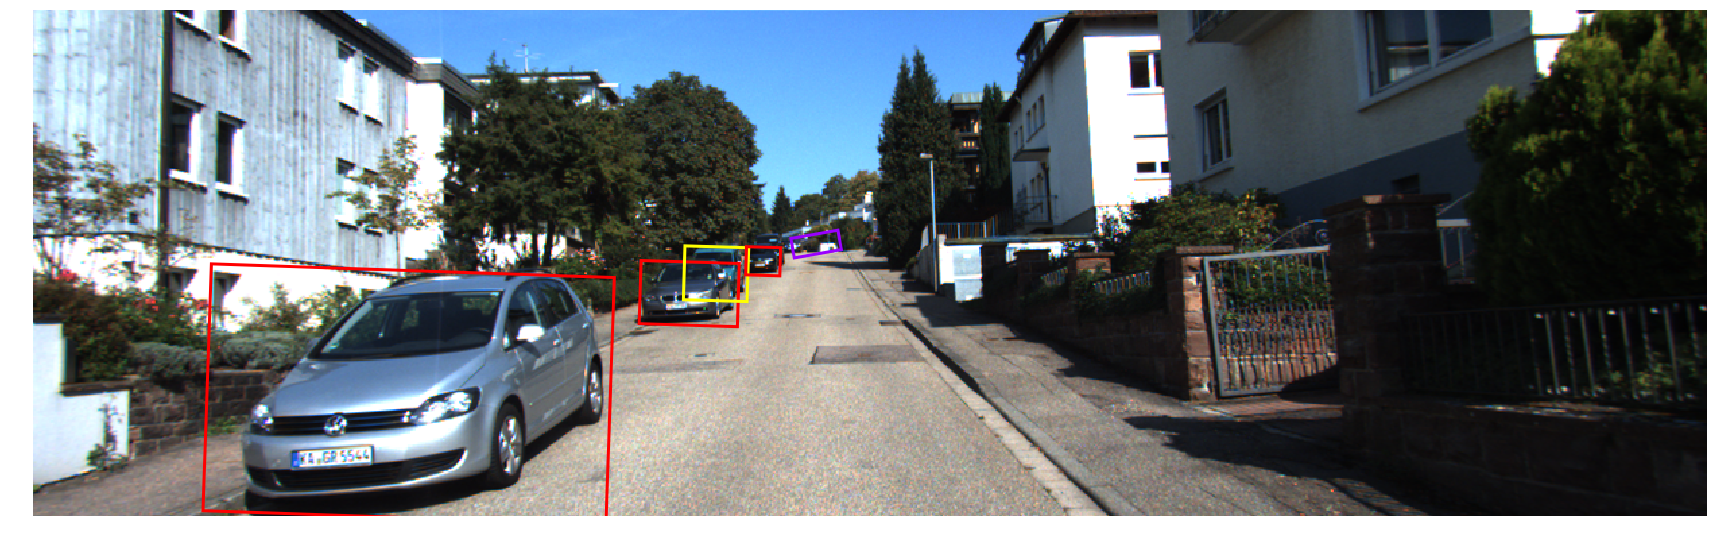

-----------------------------------------------------------------------------------
|type            |  alpha     |  x_max     |  y_max     |  y_min     |  x_min     |
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
|Car             |  1.95      |  430.83    |  370.81    |  187.57    |  131.71    |
-----------------------------------------------------------------------------------
|Car             |  1.74      |  523.42    |  231.98    |  185.08    |  450.5     |
-----------------------------------------------------------------------------------
|Car             |  1.64      |  554.02    |  195.74    |  174.85    |  528.71    |
-----------------------------------------------------------------------------------
|Van             |  1.7       |  530.38    |  214.2     |  174.23    |  483.07    |
----------------------------------------------------------------------------

In [23]:
display_im(321, 'train')